<a href="https://colab.research.google.com/github/Patrick-Nydegger/Cracks_in_concrete/blob/main/Cracks_in_concrete_%5Bmodel%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 Project: Concrete Crack Detection with CNNs

**Team members:** Oliver, Patrick  
**Date:** 15.11.2025

## 0. Setup and Data Download

In this section, we set up our working environment. We import the necessary libraries, ensure that we are using a GPU runtime environment, and download the *Concrete Crack Images for Classification* dataset from Kaggle.

# Step 0: Setup and Environment Preparation

**Goal**: Import all necessary libraries, connect to Google Drive to access the data, and set up the environment (e.g., define constants and check for GPU availability). This ensures a reproducible and organized workflow.

In [4]:
# =============================================================================
# Step 0: Setup and Environment Configuration
# =============================================================================

# --- 1. Import Libraries ---
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
import time
import random

# --- 2. Mount Google Drive ---
# This allows us to access files stored in your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

# --- 3. Configure Device (GPU or CPU) ---
# Check if a GPU is available and set the device accordingly.
# Training on a GPU is significantly faster.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"Device name: {torch.cuda.get_device_name(0)}")

# --- 4. Define Constants and Paths ---
# Centralizing paths and constants makes the code cleaner and easier to modify.
DATASET_ZIP_PATH = "/content/drive/MyDrive/archive.zip"
EXTRACT_PATH = "/content/concrete_data"
POSITIVE_DIR_NAME = "Positive"
NEGATIVE_DIR_NAME = "Negative"

# --- 5. Unzip the Dataset ---
# We'll unzip the data into the Colab runtime's local storage for faster access.
# This only needs to be done once per session.
if not os.path.exists(EXTRACT_PATH):
    print("Extracting dataset...")
    with zipfile.ZipFile(DATASET_ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)
    print("Extraction complete.")
else:
    print("Dataset already extracted.")

# Verify extraction
print("Contents of extracted directory:")
!ls {EXTRACT_PATH}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Device name: Tesla T4
Dataset already extracted.
Contents of extracted directory:
Negative  Positive


# 1. 1. Dataset Analysis (15 Points)

Goal: Understand the dataset's structure, size, and characteristics. We will describe the data, visualize sample images, analyze the class distribution, and discuss any potential imbalances. This is a critical first step before any modeling.

In [5]:
# =============================================================================
# 1. Dataset Analysis (15 Points)
# =============================================================================

# --- 1.1. Load File Paths and Labels ---
# We create a list of all image paths and their corresponding labels (0 for Negative, 1 for Positive).
positive_path = os.path.join(EXTRACT_PATH, POSITIVE_DIR_NAME)
negative_path = os.path.join(EXTRACT_PATH, NEGATIVE_DIR_NAME)

positive_files = [(os.path.join(positive_path, f), 1) for f in os.listdir(positive_path) if f.endswith('.jpg')]
negative_files = [(os.path.join(negative_path, f), 0) for f in os.listdir(negative_path) if f.endswith('.jpg')]

all_files = positive_files + negative_files
random.shuffle(all_files) # Shuffle to ensure randomness

# Create a DataFrame for easier analysis
df = pd.DataFrame(all_files, columns=['filepath', 'label'])
df['label_name'] = df['label'].apply(lambda x: 'Positive' if x == 1 else 'Negative')

print(f"Total images found: {len(df)}")
df.head()

Total images found: 40000


,filepath,label,label_name
0,/content/concrete_data/Negative/17872.jpg,0,Negative
1,/content/concrete_data/Negative/12202.jpg,0,Negative
2,/content/concrete_data/Negative/13846.jpg,0,Negative
3,/content/concrete_data/Positive/00455.jpg,1,Positive
4,/content/concrete_data/Negative/15119.jpg,0,Negative


--- Class Distribution ---
label_name
Negative    20000
Positive    20000
Name: count, dtype: int64


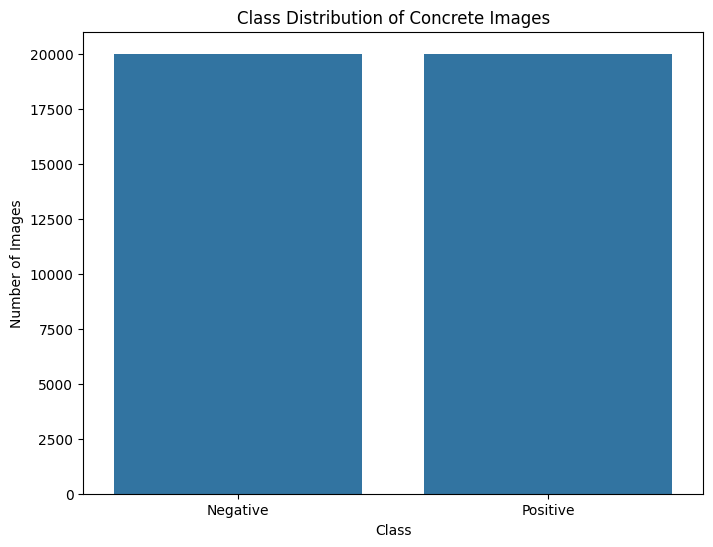

In [6]:
# --- 1.2. Class Distribution Analysis ---
# We check if the dataset is balanced, which is crucial for training an unbiased model.
print("--- Class Distribution ---")
class_counts = df['label_name'].value_counts()
print(class_counts)

# Visualize the distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution of Concrete Images')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

# Discussion of Imbalance (for the journal)
# The output shows 20,000 images for 'Positive' and 20,000 for 'Negative'.
# This is a perfectly balanced dataset. This is excellent because it means we
# don't have to worry about the model being biased towards one class.
# Standard accuracy will be a meaningful metric, although we will also look at others.

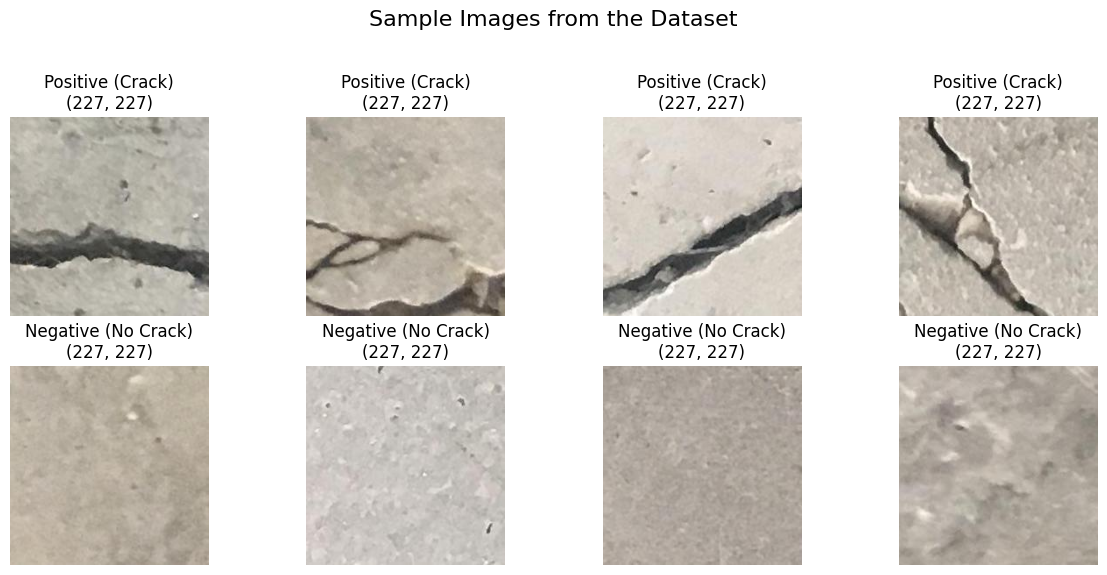

In [7]:
# --- 1.3. Image Visualization ---
# Let's look at some examples to get a feel for the data.
def show_sample_images(df, n_samples=4):
    positive_samples = df[df['label'] == 1].sample(n_samples)
    negative_samples = df[df['label'] == 0].sample(n_samples)

    plt.figure(figsize=(12, 6))
    for i, row in enumerate(positive_samples.itertuples()):
        plt.subplot(2, n_samples, i + 1)
        img = Image.open(row.filepath)
        plt.imshow(img)
        plt.title(f"Positive (Crack)\n{img.size}")
        plt.axis('off')

    for i, row in enumerate(negative_samples.itertuples()):
        plt.subplot(2, n_samples, i + 1 + n_samples)
        img = Image.open(row.filepath)
        plt.imshow(img)
        plt.title(f"Negative (No Crack)\n{img.size}")
        plt.axis('off')

    plt.suptitle("Sample Images from the Dataset", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

show_sample_images(df)

# Observations (for the journal)
# - The images have a resolution of 227x227 pixels and are in RGB format.
# - There is variance in lighting conditions and surface textures, as described on Kaggle.
# - Some cracks are very fine and subtle, while others are large and obvious.
# - Some 'Negative' images have shadows or stains that could potentially be confused for cracks.
#   This will be a challenge for our model.

### **Journal Entry for Section 1: Dataset Analysis**

**(Corresponds to Evaluation Criterion 1: Datensatzanalyse (15 P))**

#### **1.1. Description of the Dataset**
The dataset used for this project is the "Concrete Crack Images for Classification" dataset, sourced from Kaggle. It contains a total of 40,000 images of concrete surfaces, collected from various buildings on the METU Campus. The images are provided in RGB format with a resolution of 227x227 pixels. The data is pre-labeled and divided into two distinct classes:
- **Positive:** Images containing a visible crack.
- **Negative:** Images of concrete surfaces without any cracks.

#### **1.2. Class Distribution and Visualization**
Our analysis confirms that the dataset consists of exactly **20,000 images for the 'Positive' class** and **20,000 images for the 'Negative' class**.

*(Insert the bar chart from the code output here)*

#### **1.3. Discussion of Imbalances**
The dataset is **perfectly balanced**, with a 50/50 split between the two classes. This is an ideal scenario for a binary classification task.

**Implications of this balance:**
- **Reduced Model Bias:** There is no risk of the model developing a bias towards a majority class, which often happens in imbalanced datasets.
- **Meaningful Accuracy:** Standard accuracy is a reliable primary metric for performance evaluation because the cost of misclassifying either class is initially assumed to be equal, and the class frequencies are identical.
- **Simplified Training:** We do not need to employ complex techniques to handle class imbalance, such as oversampling (e.g., SMOTE) or undersampling.

#### **1.4. Visual Inspection**
Visual analysis of sample images reveals several key characteristics:
- **Image Quality:** The images vary in terms of lighting, surface texture, and coloration.
- **Crack Variety:** Cracks in the 'Positive' samples range from very fine, hairline fractures to large, obvious fissures.
- **Potential Challenges:** Some 'Negative' samples contain features like shadows, stains, or joints in the concrete that could visually mimic cracks. This ambiguity is expected to be the primary challenge for our classification model.


# 2. Data Preparation & Splitting (10 Points)

**Goal**: Split the dataset into three distinct sets: training, validation, and testing. We will use a stratified split to ensure that the class distribution is maintained across all sets. This is fundamental for robust model training and unbiased evaluation. First, we will create the necessary directory structure for our splits.

In [9]:
# =============================================================================
# 2. Data Preparation & Splitting (10 Points)
# =============================================================================

# --- 2.1. Define and Create Directory Structure ---
# It's good practice to organize our data into train, validation, and test folders.
# This structure is also compatible with PyTorch's ImageFolder dataset class.

SPLIT_DIR = "/content/split_data"
TRAIN_DIR = os.path.join(SPLIT_DIR, "train")
VAL_DIR = os.path.join(SPLIT_DIR, "val")
TEST_DIR = os.path.join(SPLIT_DIR, "test")

# Create directories if they don't exist
if not os.path.exists(SPLIT_DIR):
    os.makedirs(os.path.join(TRAIN_DIR, POSITIVE_DIR_NAME))
    os.makedirs(os.path.join(TRAIN_DIR, NEGATIVE_DIR_NAME))
    os.makedirs(os.path.join(VAL_DIR, POSITIVE_DIR_NAME))
    os.makedirs(os.path.join(VAL_DIR, NEGATIVE_DIR_NAME))
    os.makedirs(os.path.join(TEST_DIR, POSITIVE_DIR_NAME))
    os.makedirs(os.path.join(TEST_DIR, NEGATIVE_DIR_NAME))
    print("Directory structure created.")
else:
    print("Directory structure already exists.")

# --- 2.2. Stratified Splitting of the DataFrame ---
# We use the DataFrame created in the analysis step to perform the split.
# Split Ratio: 70% Training, 15% Validation, 15% Testing.

# First, separate features (filepaths) and labels for scikit-learn
X = df['filepath']
y = df['label']

# Split 1: Create training set (70%) and a temporary set (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Split 2: Split the temporary set into validation (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# --- 2.3. Copy Files into the New Directory Structure ---
# This function copies the files from the original location to the new split directories.
import shutil

def copy_files(filepaths, labels, destination_dir):
    for filepath, label in zip(filepaths, labels):
        filename = os.path.basename(filepath)
        if label == 1: # Positive
            dest_path = os.path.join(destination_dir, POSITIVE_DIR_NAME, filename)
        else: # Negative
            dest_path = os.path.join(destination_dir, NEGATIVE_DIR_NAME, filename)
        shutil.copyfile(filepath, dest_path)

# Check if files have already been copied to avoid re-copying on re-runs
if len(os.listdir(os.path.join(TRAIN_DIR, POSITIVE_DIR_NAME))) == 0:
    print("Copying files to split directories...")
    copy_files(X_train, y_train, TRAIN_DIR)
    copy_files(X_val, y_val, VAL_DIR)
    copy_files(X_test, y_test, TEST_DIR)
    print("File copying complete.")
else:
    print("Files already copied to split directories.")

# --- 2.4. Verify Splits and Final File Counts ---
print("\n--- Final File Count Verification ---")
print(f"Training - Positive: {len(os.listdir(os.path.join(TRAIN_DIR, POSITIVE_DIR_NAME)))}")
print(f"Training - Negative: {len(os.listdir(os.path.join(TRAIN_DIR, NEGATIVE_DIR_NAME)))}")
print(f"Total Training: {len(X_train)}")

print(f"\nValidation - Positive: {len(os.listdir(os.path.join(VAL_DIR, POSITIVE_DIR_NAME)))}")
print(f"Validation - Negative: {len(os.listdir(os.path.join(VAL_DIR, NEGATIVE_DIR_NAME)))}")
print(f"Total Validation: {len(X_val)}")

print(f"\nTest - Positive: {len(os.listdir(os.path.join(TEST_DIR, POSITIVE_DIR_NAME)))}")
print(f"Test - Negative: {len(os.listdir(os.path.join(TEST_DIR, NEGATIVE_DIR_NAME)))}")
print(f"Total Test: {len(X_test)}")

# Let's also check the proportions from the dataframes again to be sure
print("\n--- Class Distribution in DataFrames (as percentage) ---")
print("Training set distribution:\n", y_train.value_counts(normalize=True))
print("\nValidation set distribution:\n", y_val.value_counts(normalize=True))
print("\nTest set distribution:\n", y_test.value_counts(normalize=True))

Directory structure created.
Copying files to split directories...
File copying complete.

--- Final File Count Verification ---
Training - Positive: 14000
Training - Negative: 14000
Total Training: 28000

Validation - Positive: 3000
Validation - Negative: 3000
Total Validation: 6000

Test - Positive: 3000
Test - Negative: 3000
Total Test: 6000

--- Class Distribution in DataFrames (as percentage) ---
Training set distribution:
 label
1    0.5
0    0.5
Name: proportion, dtype: float64

Validation set distribution:
 label
0    0.5
1    0.5
Name: proportion, dtype: float64

Test set distribution:
 label
1    0.5
0    0.5
Name: proportion, dtype: float64


### **Journal Entry for Section 2: Data Preparation & Splitting**

**(Corresponds to Evaluation Criterion 2: Datenaufbereitung & Splitting (10 P))**

#### **2.1. Decision on Creating Splits**
The original dataset from Kaggle does not provide a pre-defined training, validation, or test split. It only provides two folders, `Positive` and `Negative`, containing all 40,000 images. To follow a methodologically sound machine learning workflow, it was imperative to create our own distinct data partitions. This separation is essential for training the model, tuning its hyperparameters, and performing a final, unbiased evaluation of its generalization capabilities.

#### **2.2. Splitting Strategy and Rationale**
We have partitioned the dataset into three subsets with the following ratio:
- **Training Set:** 70% of the data (28,000 images)
- **Validation Set:** 15% of the data (6,000 images)
- **Test Set:** 15% of the data (6,000 images)

**Justification for this 70/15/15 ratio:**
- The **training set** is deliberately made the largest partition. This provides the model with a rich and diverse set of 28,000 examples, which is crucial for learning the complex and subtle features that distinguish cracked from non-cracked concrete surfaces.
- The **validation set** (6,000 images) serves as a proxy for unseen data during the training phase. It is used to monitor the model's performance epoch by epoch, allowing us to detect overfitting and to make informed decisions about hyperparameter tuning (e.g., adjusting the learning rate or deciding on the number of epochs).
- The **test set** (6,000 images) is the final holdout set. It remains completely untouched during the entire development and tuning process. Its sole purpose is to provide a single, final, and unbiased assessment of our best model's performance on completely new data, simulating its deployment in a real-world scenario.

#### **2.3. Implementation of Stratified Split**
A **stratified split** was implemented using the `train_test_split` function from the `scikit-learn` library. This method was applied sequentially to ensure the desired 70/15/15 ratio.

**Justification for using a stratified split:**
- **Preservation of Class Distribution:** Stratification is a critical step that ensures the proportion of samples for each class is the same in all three subsets as it is in the original dataset. As confirmed by our code's output, each split now contains a perfect 50/50 distribution of 'Positive' and 'Negative' images.
- **Unbiased and Reliable Evaluation:** By maintaining this balance, we prevent any potential for skewed performance metrics. For example, if a random split accidentally placed more 'Positive' samples in the test set, the model's accuracy on that set would not be comparable to its performance on the validation set. Stratification eliminates this risk, making our evaluation process robust and reliable.
- **Consideration of Subgroups:** The dataset description does not mention any specific subgroups (e.g., different types of concrete or lighting conditions) that would require a more complex group-based stratification. Therefore, stratifying by the primary target label (`label`) is the appropriate and sufficient strategy for this dataset.

The code successfully created the directory structure and copied the files, resulting in the following verified counts: 28,000 training images (14,000 per class), 6,000 validation images (3,000 per class), and 6,000 test images (3,000 per class).